# Configuring Kaggle API

[Get the dataset here](https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction)<br>
Credits to [this kernel](https://www.kaggle.com/mahendrawagh), on which this notebook was based.
#Context
It is the dataset of a U.S. bank customer for getting the information that , this particular customer will leave bank or not.

#Content
Various Bank detail is given like CustomerID , surname, Credit score and many more.

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash
#Copying kaggle api key to working directory
cp drive/MyDrive/Colab\ Notebooks/kaggle.json .
# Then move kaggle.json into the folder where the API expects to find it.
mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d shantanudhakadd/bank-customer-churn-prediction --force && unzip bank-customer-churn-prediction.zip

# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import callbacks
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score

In [7]:
mpl.rcParams['figure.dpi'] = 200
sns.set_style('darkgrid')
sns.set_palette('deep')

In [45]:
# reading input data
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Preprocessing

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [47]:
## checking for null values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [48]:
## deleting not relevant columns
del data['CustomerId']
del data['RowNumber']

In [49]:
## encoding categorical variables
le = LabelEncoder()
data['Surname'] = le.fit_transform(data['Surname'])
data["Geography"]=le.fit_transform(data["Geography"])
data["Gender"]=le.fit_transform(data["Gender"])

In [50]:
data.head()

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1115,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,1177,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,2040,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,289,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,1822,850,2,0,43,2,125510.82,1,1,1,79084.10,0


## Data Visualization

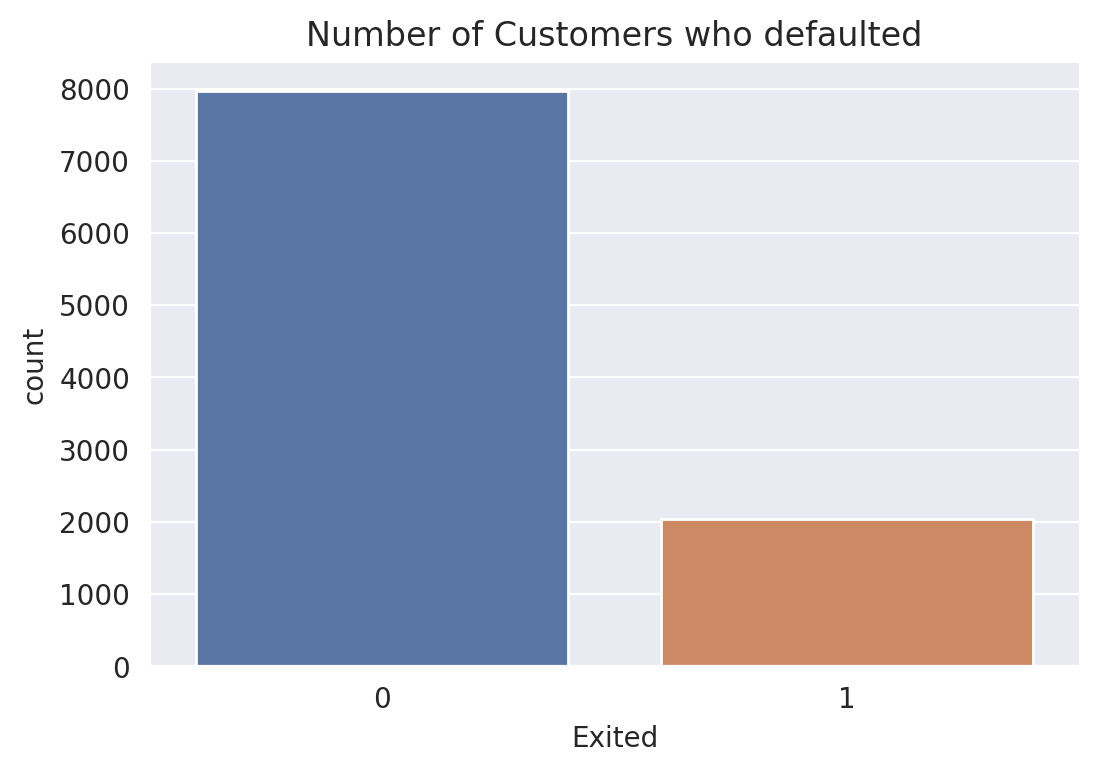

In [14]:
x=data.iloc[:,:-1].values
y=data.iloc[:,-1].values
plt.title('Number of Customers who defaulted')
sns.countplot(x=data["Exited"])

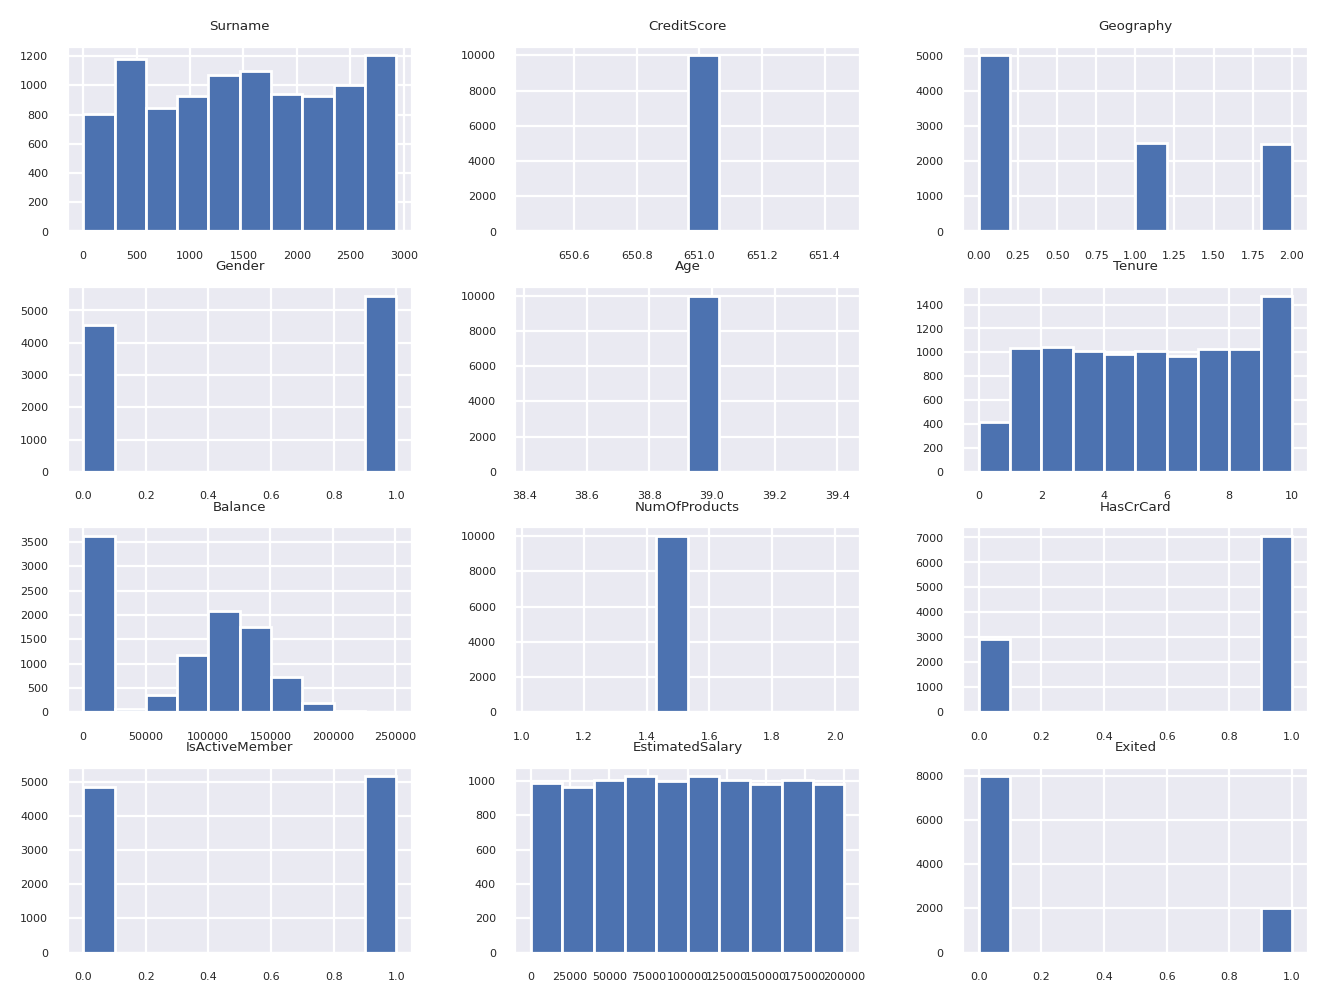

In [29]:
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 4
ax = data.hist()

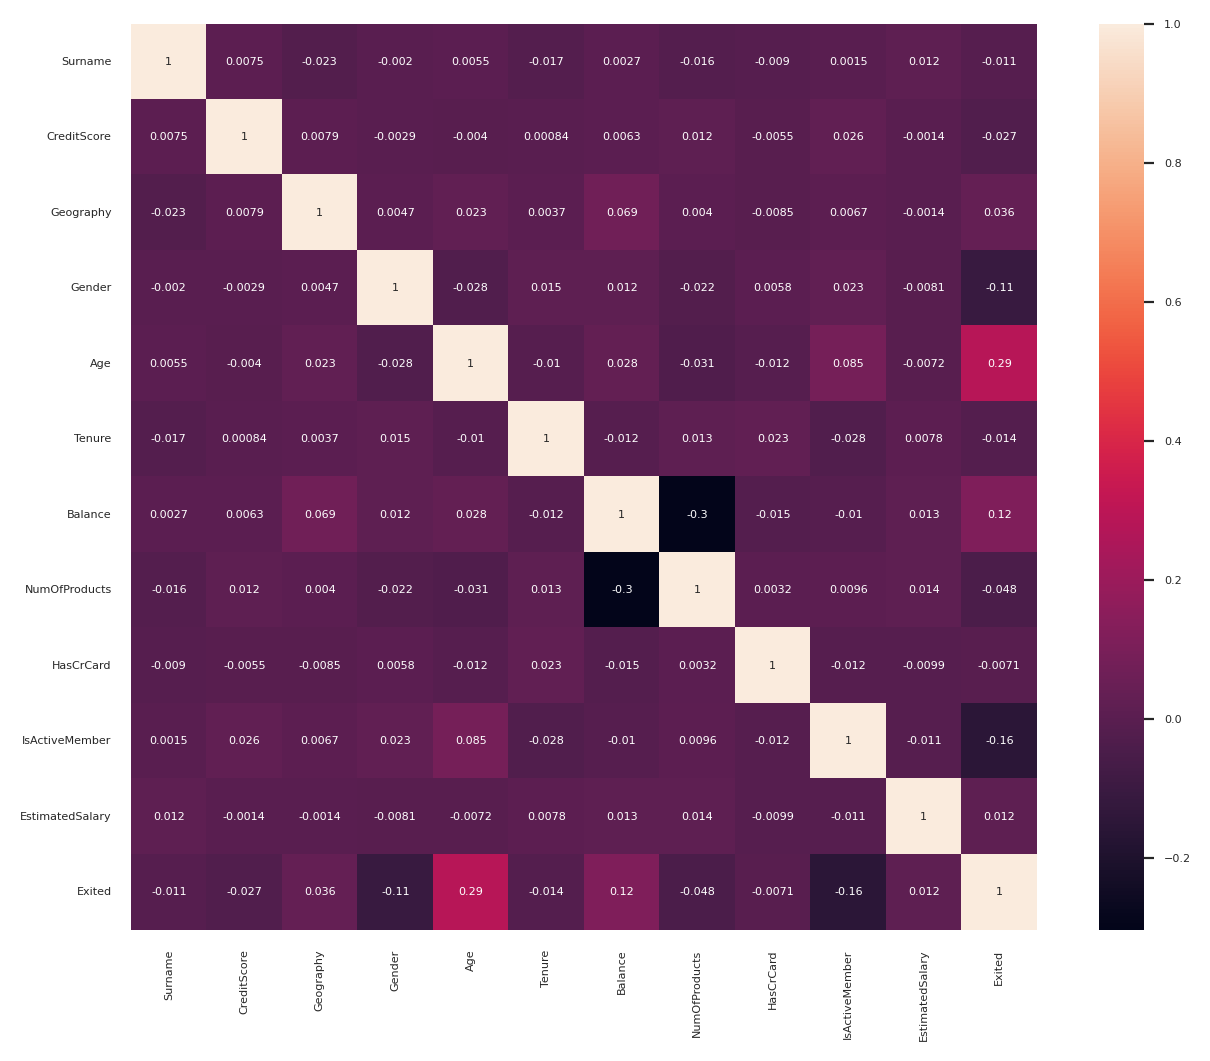

In [51]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, square=True)

# Outlier Detection

In [17]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
((data < (Q1 - 1.5 * IQR)) | (data> (Q3 + 1.5 * IQR))).sum()

Surname               0
CreditScore          15
Geography             0
Gender                0
Age                 359
Tenure                0
Balance               0
NumOfProducts        60
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited             2037
dtype: int64

In [18]:
for col in data.columns:
    if data[col].dtypes != 'object':
        q1 , q3 =data[col].quantile(0.25),data[col].quantile(0.75)
        iqr = q3 - q1
        ll = q1-1.5*iqr
        ul = q3 + 1.5*iqr
        data['CreditScore'] = np.where(data['CreditScore'] > ul, data['CreditScore'].mean(), np.where(data['CreditScore'] < ll, data['CreditScore'].mean(), data['CreditScore']))
        data["Age"] = np.where(data["Age"]>ul,data["Age"].mean(),np.where(data["Age"]<ll,data["Age"].mean(),data["Age"]))  
        data["NumOfProducts"] = np.where(data["NumOfProducts"]>ul,data["NumOfProducts"].mean(),np.where(data["NumOfProducts"]<ll,data["NumOfProducts"].mean(),data["NumOfProducts"]))

In [19]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
((data < (Q1 - 1.5 * IQR)) | (data> (Q3 + 1.5 * IQR))).sum()

Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited             2037
dtype: int64

# Dealing with data imbalance

In [20]:
S=RandomOverSampler()
x_data, y_data = S.fit_resample(x,y)
print(Counter(y_data))

Counter({1: 7963, 0: 7963})


# Data Normalization

In [21]:
mms = MinMaxScaler()
d = mms.fit_transform(x_data)

# Train test splitting

In [22]:
x_train,x_test,y_train,y_test=train_test_split(d,y_data,random_state=250,test_size=0.25)

# Model training

In [23]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=25, activation='relu'))
model.add(tf.keras.layers.Dense(units=8, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=20, epochs=100, validation_split=0.25)

Epoch 1/100
448/448 [==============================] - 6s 4ms/step - loss: 0.6475 - accuracy: 0.6270 - val_loss: 0.6130 - val_accuracy: 0.6658
Epoch 2/100
448/448 [==============================] - 2s 3ms/step - loss: 0.5977 - accuracy: 0.6804 - val_loss: 0.5850 - val_accuracy: 0.6835
Epoch 3/100
448/448 [==============================] - 2s 3ms/step - loss: 0.5727 - accuracy: 0.7012 - val_loss: 0.5825 - val_accuracy: 0.6792
Epoch 4/100
448/448 [==============================] - 2s 3ms/step - loss: 0.5552 - accuracy: 0.7120 - val_loss: 0.5577 - val_accuracy: 0.6952
Epoch 5/100
448/448 [==============================] - 2s 4ms/step - loss: 0.5392 - accuracy: 0.7240 - val_loss: 0.5550 - val_accuracy: 0.7040
Epoch 6/100
448/448 [==============================] - 2s 4ms/step - loss: 0.5283 - accuracy: 0.7368 - val_loss: 0.5298 - val_accuracy: 0.7317
Epoch 7/100
448/448 [==============================] - 2s 4ms/step - loss: 0.5168 - accuracy: 0.7472 - val_loss: 0.5198 - val_accuracy: 0.7274

## making inference

In [32]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

125/125 [==============================] - 1s 3ms/step


# Confusion Matrix

array([[1534,  450],
       [ 409, 1589]])

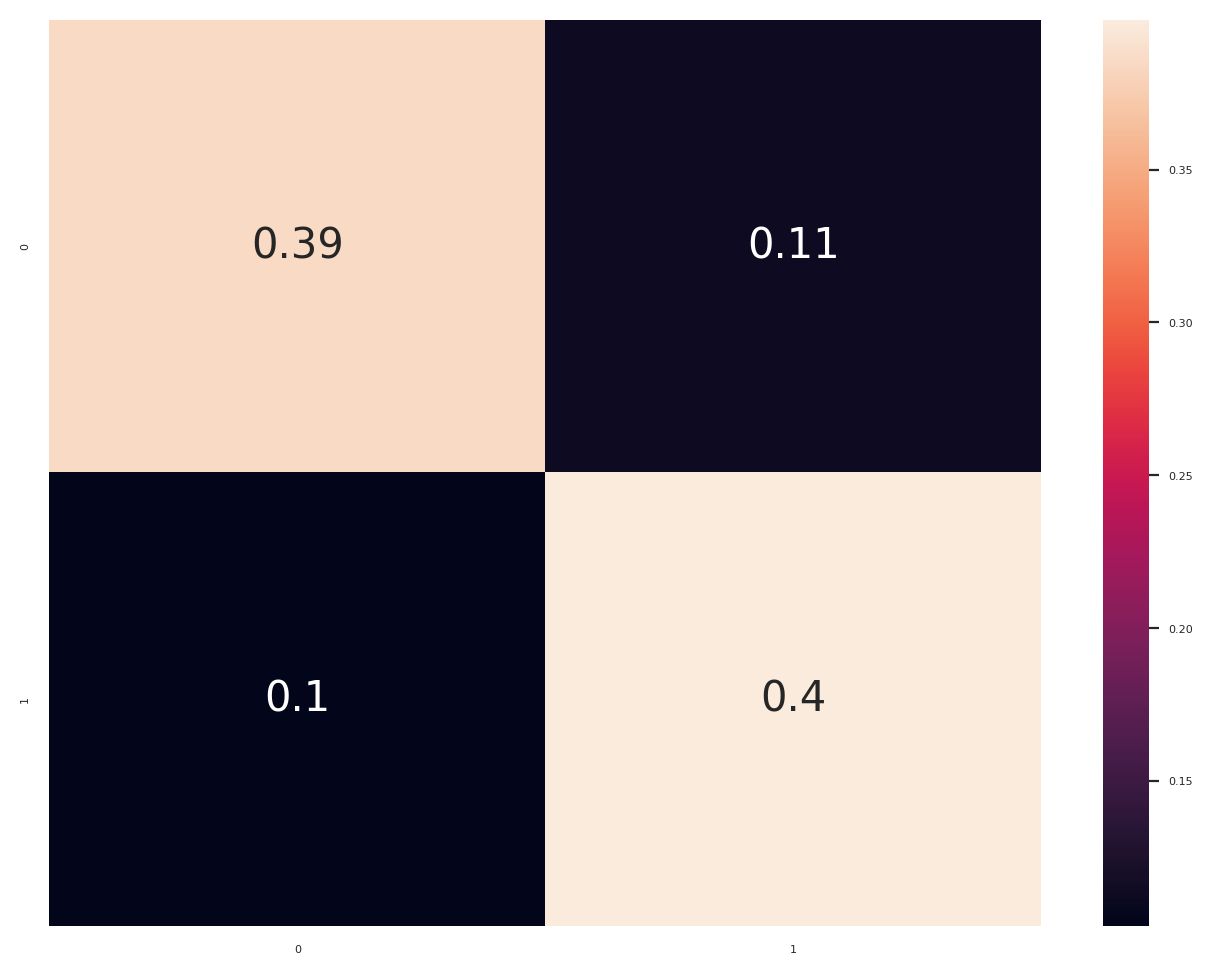

In [35]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True, annot_kws = {'size':15})
cf_matrix

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1984
           1       0.78      0.80      0.79      1998

    accuracy                           0.78      3982
   macro avg       0.78      0.78      0.78      3982
weighted avg       0.78      0.78      0.78      3982



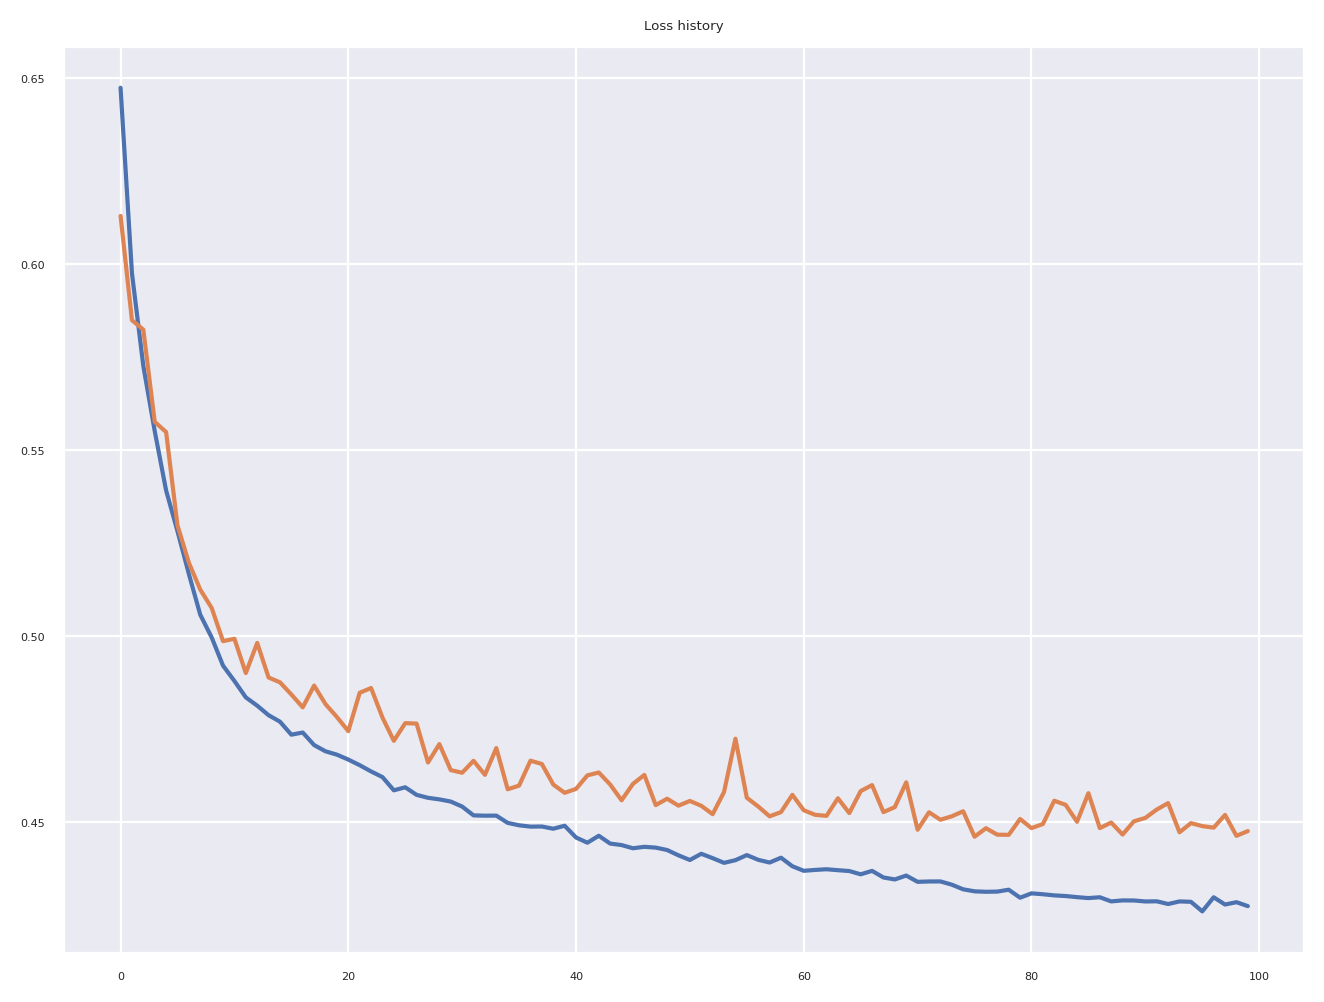

In [41]:
# Analysing model history
plt.title('Loss history')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

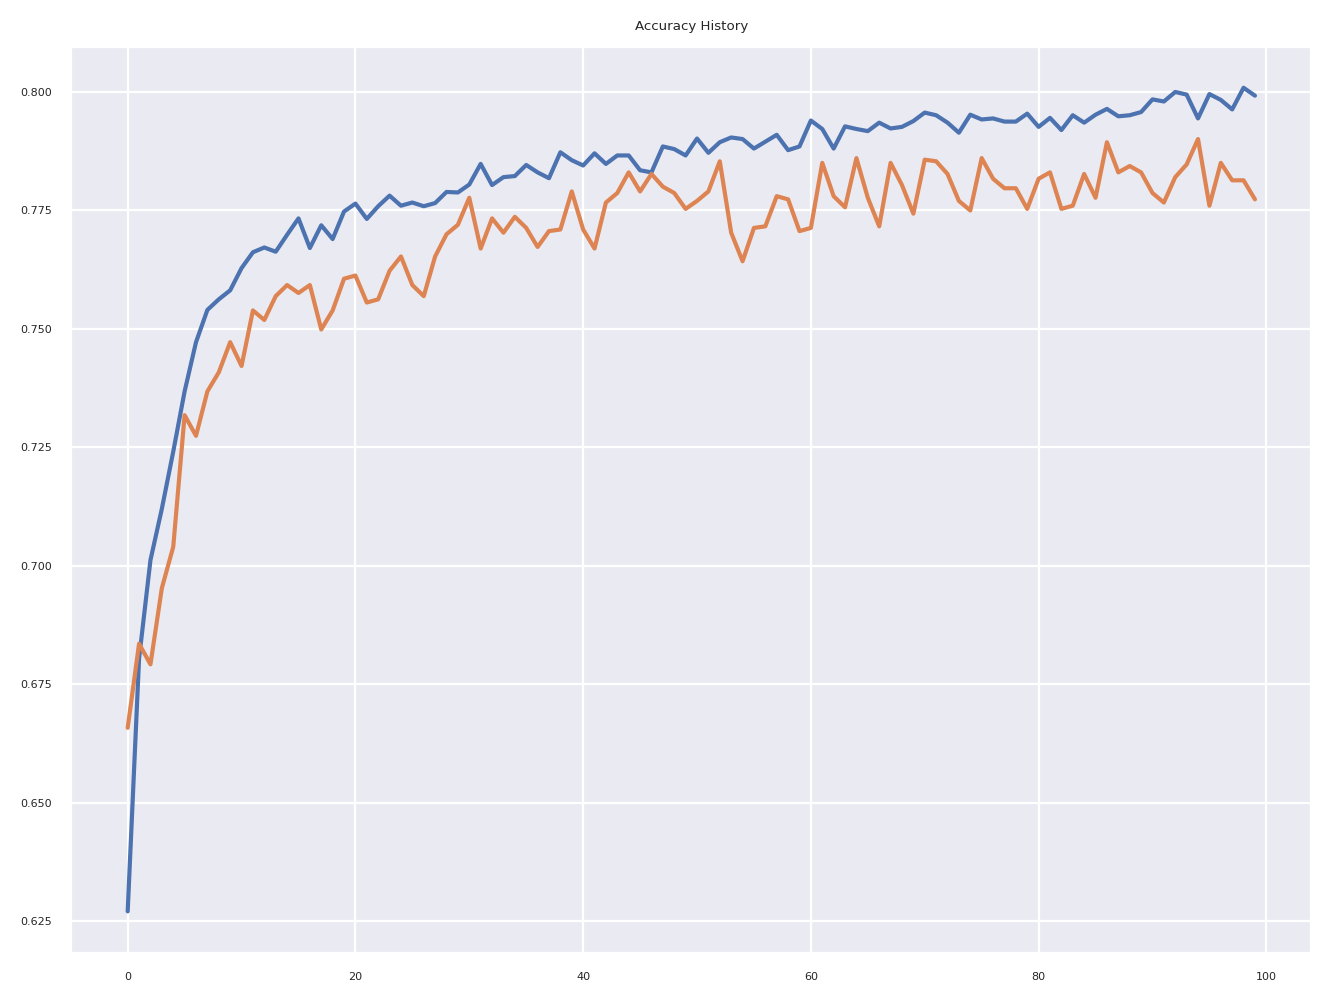

In [42]:
plt.title('Accuracy History')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])